# Real-World Data Demonstration

### Team Epsilon-Greedy Quants
#### Michael Lee, Nikat Patel, Jose Antonio Alatorre Sanchez

This notebook demonstrates what a user sees when the user runs the User Guide for Real-World Data Notebook

In [1]:
from environments.e_greedy import DeepTradingEnvironment, LinearAgent

import datetime
import numpy as np
import pandas as pd
import os
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.cla import CLA
import matplotlib.pyplot as plt
from matplotlib import cm
import copy
import quantstats as qs
qs.extend_pandas()

In [2]:
root = os.getcwd()
data_env = root+"/data_env/"

# Utility Functions

In [3]:
def _retrieve_asset_dict():
    # obtain close prices from parquet files of ETF price history
    root = os.getcwd()
    data_env = root+"/data_env/"
    files = [_ for _ in os.listdir(data_env) if "parquet" in _]
    assets_dict = {file: pd.read_parquet(data_env + "/" + file) for file in files}
    counter=0
    for key, value in assets_dict.items():
        if counter==0:
            main_index=value.index
    else:
        main_index=main_index.join(value.index,how="inner")
        
    for key, value in assets_dict.items():
        tmp_df=value.reindex(main_index)
        tmp_df=tmp_df.fillna(method='ffill')
        assets_dict[key]=tmp_df['close']
    return assets_dict

def build_portfolio_df(asset_dict):
    portfolio_df = pd.DataFrame()
    
    for key, value in assets_dict.items():
        key = key.split(".")[0]
        tmp_df = pd.DataFrame(data=value)
        tmp_df.columns=[key]
        portfolio_df = pd.concat([portfolio_df, tmp_df], axis=1)
        
    portfolio_df.index = pd.to_datetime(portfolio_df.index, errors='coerce')
    return portfolio_df

In [4]:
def plot_backtest(linear_agent_train, env_test, test_input, model):
    ## Create plot of backtest returns
    if not "backtest" in locals():
        backtest=None
    backtest, tmp_weights =linear_agent_train.backtest_policy(epoch=1,backtest=backtest, env_test=env_test, test_input=test_input)
    plt.figure(figsize=(8,4))
    plt.plot(backtest,color="blue")
    plt.gcf().autofmt_xdate()
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel("Date", fontsize = 10)
    plt.ylabel("Backtest", fontsize = 10)
    plt.title("Backtest on Test Data: "+ model,fontsize = 16)
    plt.savefig(root+'/temp_persisted_data/backtest_'+model+'.png')
    tmp_weights.to_csv(root+'/temp_persisted_data/backtest_weights_'+model+'.csv')
    plt.show()
    return backtest

# Reviewing Real-World Data

In [5]:
# read a sample ETF
pd.read_parquet(data_env+'EEMV.parquet').head()

,open,high,low,close,volume
index,,,,,
2017-01-03 05:00:00+00:00,45.08700,45.26144,44.93093,45.07782,926496
2017-01-04 05:00:00+00:00,45.50014,45.63785,45.50014,45.54604,973660
2017-01-05 05:00:00+00:00,45.92245,46.16116,45.92245,46.14280,646347
2017-01-06 05:00:00+00:00,45.94082,45.94082,45.74802,45.81229,563348
2017-01-09 05:00:00+00:00,45.71130,45.79393,45.65621,45.71130,615522


In [6]:
# create a portfolio
assets_dict = _retrieve_asset_dict()
portfolio_df = build_portfolio_df(assets_dict)

In [7]:
# create a train dataset and de-mean the time series

portfolio_df_train = portfolio_df[portfolio_df.index <= '2020-04-01']
portfolio_df_train.sub(portfolio_df_train.mean())

portfolio_df_train.head()

,EEMV,EFAV,MTUM,QUAL,SIZE,USMV,VLUE
index,,,,,,,
2017-01-03 05:00:00+00:00,45.07782,54.69828,72.54646,65.02215,67.17120,42.06556,64.23762
2017-01-04 05:00:00+00:00,45.54604,55.25160,72.97556,65.38650,67.97419,42.26039,64.91695
2017-01-05 05:00:00+00:00,46.14280,55.90309,73.21394,65.32110,67.81546,42.30678,64.56370
2017-01-06 05:00:00+00:00,45.81229,55.76030,73.63351,65.54532,68.04888,42.36245,64.50029
2017-01-09 05:00:00+00:00,45.71130,55.76923,73.60490,65.21833,67.72208,42.15833,64.26479


In [8]:
# create a test dataset consisting of 6 months of data and de-mean the time series

portfolio_df_test = portfolio_df[portfolio_df.index >= '2020-04-16']
portfolio_df_test = portfolio_df_test[portfolio_df_test.index <= '2020-11-16']
portfolio_df_test.sub(portfolio_df_test.mean())

portfolio_df_test.head()

,EEMV,EFAV,MTUM,QUAL,SIZE,USMV,VLUE
index,,,,,,,
2020-04-16 04:00:00+00:00,48.20911,62.50506,116.0638,86.18110,75.67554,57.85078,65.36022
2020-04-17 04:00:00+00:00,48.88692,63.45106,117.9653,88.67091,78.40196,59.53394,67.65253
2020-04-20 04:00:00+00:00,48.48617,62.79575,116.7009,87.05402,77.06354,58.23692,66.08150
2020-04-21 04:00:00+00:00,47.54613,61.94337,112.3304,84.47494,74.79317,56.78149,63.82873
2020-04-22 04:00:00+00:00,48.56533,62.75141,115.3270,86.41917,76.31997,57.81118,65.00452


In [9]:
test_input_returns = portfolio_df_test.to_returns().dropna()
test_input_returns = test_input_returns.loc[(test_input_returns != 0).any(1)]


# Set Up Environment

In [10]:
# parameters related to the transformation of data, this parameters govern an step before the algorithm
out_reward_window=datetime.timedelta(days=7)

meta_parameters = {"in_bars_count": 14,
                   "out_reward_window":out_reward_window ,
                   "state_type":"in_window_out_window",
                   "risk_aversion":10,
                   "include_previous_weights":False}

# parameters that are related to the objective/reward function construction
objective_parameters = {"percent_commission": .001}

print("===Meta Parameters===")
print(meta_parameters)
print("===Objective Parameters===")
print(objective_parameters)

# create an environment and build features based on Real-World Dataset located in the "data_env" folder 
env = DeepTradingEnvironment.build_environment_from_dirs_and_transform(meta_parameters, objective_parameters,data_hash="real_data", data_dir="data_env")

number_of_assets = env.number_of_assets

===Meta Parameters===
{'in_bars_count': 14, 'out_reward_window': datetime.timedelta(days=7), 'state_type': 'in_window_out_window', 'risk_aversion': 10, 'include_previous_weights': False}
===Objective Parameters===
{'percent_commission': 0.001}


#### Split Features and Forward Returns into Training and Test sets

In [11]:
features = pd.read_parquet("temp_persisted_data/only_features_real_data")

features_train = features[features.index <= '2020-04-01']
features_train.sub(features_train.mean()) 

features_test = features[features.index >= '2020-04-16']
features_test = features_test[features_test.index <= '2020-11-16']
features_test.sub(features_test.mean())

features_test.head()

,EEMV.parquet_log_returns,EFAV.parquet_log_returns,MTUM.parquet_log_returns,QUAL.parquet_log_returns,SIZE.parquet_log_returns,USMV.parquet_log_returns,VLUE.parquet_log_returns,EEMV.parquet_log_returns_lag_0,EFAV.parquet_log_returns_lag_0,MTUM.parquet_log_returns_lag_0,...,USMV.parquet_log_returns_lag_12,VLUE.parquet_log_returns_lag_12,EEMV.parquet_log_returns_lag_13,EFAV.parquet_log_returns_lag_13,MTUM.parquet_log_returns_lag_13,QUAL.parquet_log_returns_lag_13,SIZE.parquet_log_returns_lag_13,USMV.parquet_log_returns_lag_13,VLUE.parquet_log_returns_lag_13,bias
index,,,,,,,,,,,,,,,,,,,,,
2020-04-16 04:00:00+00:00,-0.004097,0.003949,0.015996,0.002074,0.000393,0.005147,-0.002868,-0.015416,-0.020832,-0.012903,...,-0.021026,-0.038587,0.035069,0.048233,0.063901,0.054616,0.058099,0.067378,0.062540,1
2020-04-17 04:00:00+00:00,0.013962,0.015021,0.016250,0.028481,0.035394,0.028680,0.034471,-0.004097,0.003949,0.015996,...,0.031556,0.027913,-0.044196,-0.022524,-0.019721,-0.031580,-0.030387,-0.021026,-0.038587,1
2020-04-20 04:00:00+00:00,-0.008231,-0.010382,-0.010776,-0.018403,-0.017219,-0.022027,-0.023496,0.013962,0.015021,0.016250,...,-0.024869,-0.020425,0.012582,0.022205,0.031352,0.036687,0.024547,0.031556,0.027913,1
2020-04-21 04:00:00+00:00,-0.019578,-0.013667,-0.038170,-0.030074,-0.029904,-0.025309,-0.034685,-0.008231,-0.010382,-0.010776,...,-0.039080,-0.057158,0.011360,-0.012651,-0.030977,-0.017249,-0.018927,-0.024869,-0.020425,1
2020-04-22 04:00:00+00:00,0.021210,0.012960,0.026327,0.022755,0.020208,0.017972,0.018253,-0.019578,-0.013667,-0.038170,...,0.022088,0.013687,-0.038454,-0.037939,-0.049969,-0.042603,-0.051603,-0.039080,-0.057158,1


In [12]:
forward_return_dates = pd.read_parquet("temp_persisted_data/forward_return_dates_real_data")

forward_return_dates_train = forward_return_dates[forward_return_dates.index <= '2020-04-01']

forward_return_dates_test = forward_return_dates[forward_return_dates.index > '2020-04-16']
forward_return_dates_test = forward_return_dates_test[forward_return_dates_test.index <= '2020-11-16']

forward_return_dates_test.head()

,"forward_return_7_days,_0:00:00"
index,
2020-04-16 04:00:00+00:00,2020-04-23 04:00:00+00:00
2020-04-17 04:00:00+00:00,2020-04-24 04:00:00+00:00
2020-04-20 04:00:00+00:00,2020-04-27 04:00:00+00:00
2020-04-21 04:00:00+00:00,2020-04-28 04:00:00+00:00
2020-04-22 04:00:00+00:00,2020-04-29 04:00:00+00:00


In [13]:
forward_returns = pd.read_parquet("temp_persisted_data/only_forward_returns_real_data")

forward_returns_train = forward_returns[forward_returns.index <= '2020-04-01']
forward_returns_train.sub(forward_returns_train.mean()) 

forward_returns_test = forward_returns[forward_returns.index >= '2020-04-16']
forward_returns_test = forward_returns_test[forward_returns_test.index <= '2020-11-16']
forward_returns_test.sub(forward_returns_test.mean()) 

forward_returns_test.head()

,"EEMV.parquet_forward_return_7_days,_0:00:00","EFAV.parquet_forward_return_7_days,_0:00:00","MTUM.parquet_forward_return_7_days,_0:00:00","QUAL.parquet_forward_return_7_days,_0:00:00","SIZE.parquet_forward_return_7_days,_0:00:00","USMV.parquet_forward_return_7_days,_0:00:00","VLUE.parquet_forward_return_7_days,_0:00:00"
index,,,,,,,
2020-04-16 04:00:00+00:00,0.008621,-0.002207,-0.009007,0.001727,0.010481,-0.008215,-0.002268
2020-04-17 04:00:00+00:00,-0.004554,-0.007455,-0.010802,-0.010963,-0.011002,-0.027441,-0.021908
2020-04-20 04:00:00+00:00,0.022653,0.013103,0.012626,0.024727,0.032163,0.010031,0.026166
2020-04-21 04:00:00+00:00,0.044121,0.030385,0.038908,0.056130,0.069989,0.035745,0.074304
2020-04-22 04:00:00+00:00,0.042176,0.029758,0.036516,0.059458,0.078072,0.027059,0.094695


# Run Policy-Gradient Method Algorithms on Real-World Data

In [14]:
max_iter = 4000
model_run = "demeaned_return_reward_variance_risk_10_"
sample_observations = 32

### REINFORCE

 50%|███████████████████████████████████████                                       | 2000/4000 [04:50<04:12,  7.91it/s]

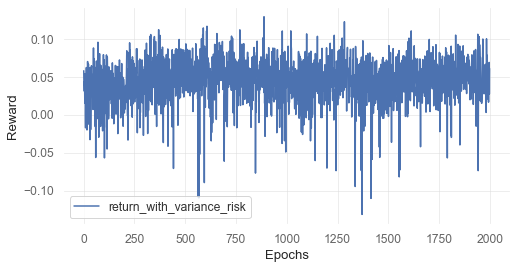

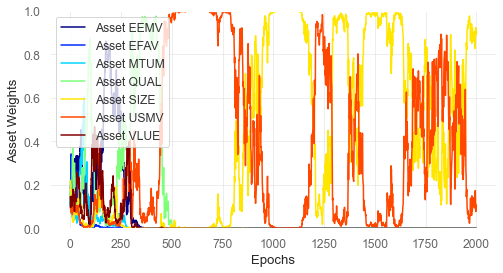

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [10:03<00:00,  5.17it/s]

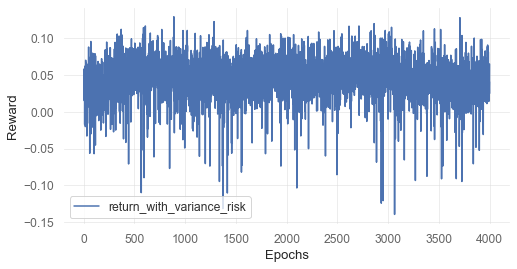

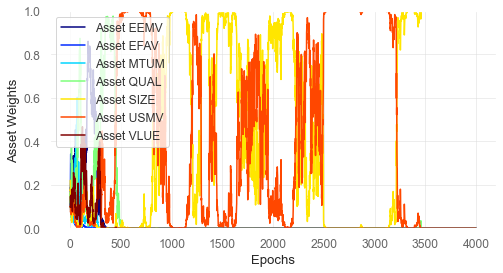

[]

In [15]:
# create environment and run REINFORCE

env_reinforce_train=DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_reinforce_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_reinforce = LinearAgent(environment=env_reinforce_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_reinforce.REINFORCE_fit(max_iterations=max_iter, add_baseline=False, verbose=True)

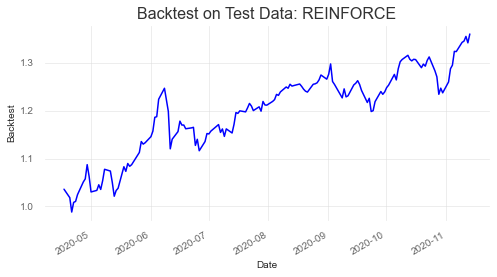

In [16]:
# perform backtest 
backtest_reinforce = plot_backtest(linear_agent_reinforce, env_reinforce_test, portfolio_df_test, model="REINFORCE")
backtest_reinforce.to_csv('temp_persisted_data/'+model_run+'backtest_reinforce.csv')

<AxesSubplot:xlabel='index'>

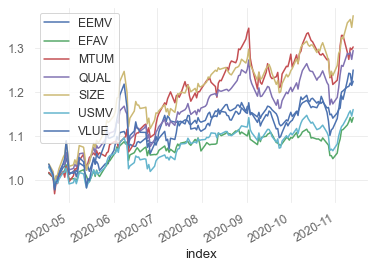

In [17]:
(test_input_returns+1).cumprod().plot()

<AxesSubplot:xlabel='index'>

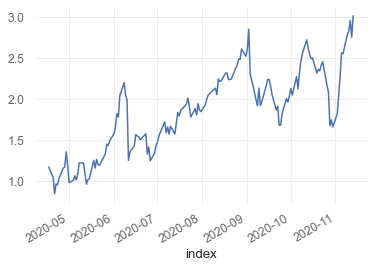

In [18]:
(test_input_returns.sum(axis=1)+1).cumprod().plot()

### REINFORCE with Baseline


pre-sampling indices:  87%|██████████████████████████████████████████████████▍       | 343/394 [00:07<00:01, 45.14it/s]


pre-sampling indices: 100%|██████████████████████████████████████████████████████████| 394/394 [00:08<00:00, 46.17it/s]

  1%|█▏                                                                              | 57/4000 [00:12<13:52,  4.74it/s]


  3%|██▍                                                                            | 123/4000 [00:27<19:11,  3.37it/s]


  5%|███▋                                                                           | 189/4000 [00:43<14:14,  4.46it/s]


  6%|█████                                                                          | 255/4000 [00:57<12:23,  5.04it/s]


  8%|██████▎                                                                        | 321/4000 [01:12<13:51,  4.43it/s]


 10%|███████▋                                                                       | 387/4000 [01:27<16:35,  3.63it/s]


 11%|████████▉                                                                      | 453/4000 [01:42<12:24,  4.76it/s]


 13%|██████████▎                                                                    | 519/4000 [01:57<10:58,  5.29it/s]


 15%|███████████▌                                                                   | 585/4000 [02:09<10:36,  5.37it/s]


 16%|████████████▊                                                                  | 651/4000 [02:25<16:45,  3.33it/s]


 18%|██████████████▏                                                                | 717/4000 [02:40<11:05,  4.93it/s]


 20%|███████████████▍                                                               | 783/4000 [02:54<12:49,  4.18it/s]


 21%|████████████████▊                                                              | 849/4000 [03:07<12:02,  4.36it/s]


 23%|██████████████████                                                             | 915/4000 [03:20<09:49,  5.23it/s]


 25%|███████████████████▎                                                           | 981/4000 [03:35<10:22,  4.85it/s]


 26%|████████████████████▍                                                         | 1047/4000 [03:50<13:00,  3.78it/s]


 28%|█████████████████████▋                                                        | 1113/4000 [04:05<12:06,  3.97it/s]


 29%|██████████████████████▉                                                       | 1179/4000 [04:18<10:13,  4.60it/s]


 31%|████████████████████████▎                                                     | 1245/4000 [04:33<09:35,  4.79it/s]


 33%|█████████████████████████▌                                                    | 1311/4000 [04:47<11:29,  3.90it/s]


 34%|██████████████████████████▊                                                   | 1377/4000 [05:03<09:05,  4.81it/s]


 36%|████████████████████████████▏                                                 | 1443/4000 [05:18<11:40,  3.65it/s]


 38%|█████████████████████████████▍                                                | 1509/4000 [05:33<10:19,  4.02it/s]


 39%|██████████████████████████████▋                                               | 1575/4000 [05:50<08:35,  4.71it/s]


 41%|███████████████████████████████▉                                              | 1641/4000 [06:04<07:15,  5.42it/s]


 43%|█████████████████████████████████▎                                            | 1707/4000 [06:17<07:29,  5.10it/s]


 44%|██████████████████████████████████▌                                           | 1773/4000 [06:31<07:12,  5.14it/s]


 46%|███████████████████████████████████▊                                          | 1839/4000 [06:44<07:01,  5.12it/s]


 48%|█████████████████████████████████████▏                                        | 1905/4000 [06:57<07:57,  4.39it/s]


 49%|██████████████████████████████████████▍                                       | 1971/4000 [07:10<07:33,  4.48it/s]


 50%|███████████████████████████████████████                                       | 2000/4000 [07:17<07:21,  4.53it/s]

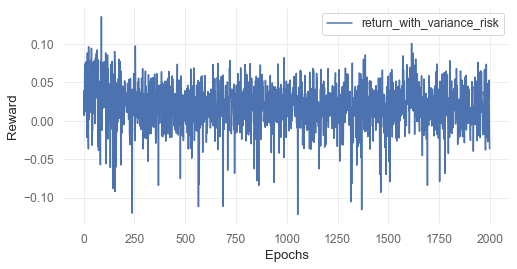

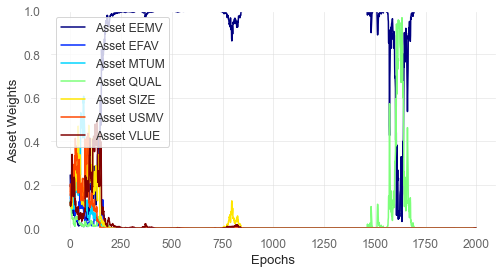


 52%|████████████████████████████████████████▎                                     | 2066/4000 [07:32<05:50,  5.51it/s]


 53%|█████████████████████████████████████████▌                                    | 2132/4000 [07:45<05:34,  5.58it/s]


 55%|██████████████████████████████████████████▊                                   | 2198/4000 [07:59<06:16,  4.78it/s]


 57%|████████████████████████████████████████████▏                                 | 2264/4000 [08:13<07:19,  3.95it/s]


 58%|█████████████████████████████████████████████▍                                | 2330/4000 [08:27<05:31,  5.04it/s]


 60%|██████████████████████████████████████████████▋                               | 2396/4000 [08:40<05:20,  5.01it/s]


 62%|████████████████████████████████████████████████                              | 2462/4000 [08:55<04:53,  5.24it/s]


 63%|█████████████████████████████████████████████████▎                            | 2528/4000 [09:08<06:26,  3.81it/s]


 65%|██████████████████████████████████████████████████▌                           | 2594/4000 [09:22<04:19,  5.42it/s]


 66%|███████████████████████████████████████████████████▊                          | 2660/4000 [09:35<04:26,  5.02it/s]


 68%|█████████████████████████████████████████████████████▏                        | 2726/4000 [09:51<06:36,  3.21it/s]


 70%|██████████████████████████████████████████████████████▍                       | 2792/4000 [10:05<06:27,  3.12it/s]


 71%|███████████████████████████████████████████████████████▋                      | 2858/4000 [10:19<03:30,  5.41it/s]


 73%|█████████████████████████████████████████████████████████                     | 2924/4000 [10:32<03:16,  5.47it/s]


 75%|██████████████████████████████████████████████████████████▎                   | 2990/4000 [10:48<03:45,  4.47it/s]


 76%|███████████████████████████████████████████████████████████▌                  | 3056/4000 [11:02<03:04,  5.12it/s]


 78%|████████████████████████████████████████████████████████████▉                 | 3122/4000 [11:16<02:54,  5.02it/s]


 80%|██████████████████████████████████████████████████████████████▏               | 3188/4000 [11:30<03:27,  3.91it/s]


 81%|███████████████████████████████████████████████████████████████▍              | 3254/4000 [11:44<02:21,  5.26it/s]


 83%|████████████████████████████████████████████████████████████████▋             | 3320/4000 [11:58<03:26,  3.29it/s]


 85%|██████████████████████████████████████████████████████████████████            | 3386/4000 [12:14<01:53,  5.39it/s]


 86%|███████████████████████████████████████████████████████████████████▎          | 3452/4000 [12:28<02:31,  3.62it/s]


 88%|████████████████████████████████████████████████████████████████████▌         | 3518/4000 [12:41<02:02,  3.95it/s]


 90%|█████████████████████████████████████████████████████████████████████▉        | 3584/4000 [12:54<01:16,  5.43it/s]


 91%|███████████████████████████████████████████████████████████████████████▏      | 3650/4000 [13:08<01:35,  3.65it/s]


 93%|████████████████████████████████████████████████████████████████████████▍     | 3716/4000 [13:22<00:57,  4.90it/s]


 95%|█████████████████████████████████████████████████████████████████████████▋    | 3782/4000 [13:35<00:48,  4.45it/s]


 96%|███████████████████████████████████████████████████████████████████████████   | 3848/4000 [13:50<00:28,  5.29it/s]


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3914/4000 [14:03<00:20,  4.22it/s]


100%|█████████████████████████████████████████████████████████████████████████████▌| 3980/4000 [14:17<00:04,  4.51it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [14:20<00:00,  5.21it/s]

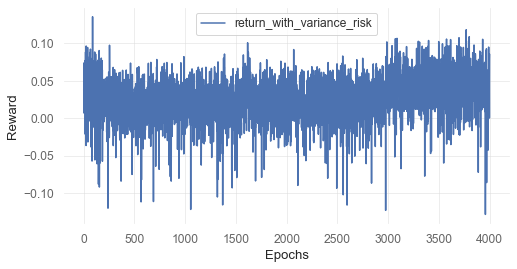

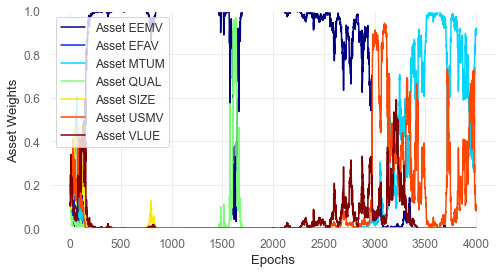

[]

In [19]:
# create environment and run REINFORCE with baseline
env_reinforce_baseline_train = DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_reinforce_baseline_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_reinforce_baseline = LinearAgent(environment=env_reinforce_baseline_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_reinforce_baseline.REINFORCE_fit(max_iterations=max_iter, add_baseline=True, verbose=True)

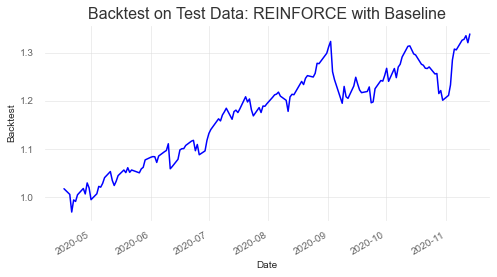

In [20]:
# perform backtest 
backtest_reinforce_baseline = plot_backtest(linear_agent_reinforce_baseline, env_reinforce_baseline_test, portfolio_df_test, model="REINFORCE with Baseline")
backtest_reinforce_baseline.to_csv('temp_persisted_data/'+model_run+'backtest_reinforce_baseline.csv')

### Actor-Critic



pre-sampling indices:   0%|                                                                    | 0/394 [00:00<?, ?it/s]

pre-sampling indices:   2%|▉                                                           | 6/394 [00:00<00:06, 55.55it/s]

pre-sampling indices:   3%|█▉                                                         | 13/394 [00:00<00:06, 57.76it/s]

pre-sampling indices:   5%|██▋                                                        | 18/394 [00:00<00:07, 53.25it/s]

pre-sampling indices:   6%|███▎                                                       | 22/394 [00:00<00:08, 45.31it/s]

pre-sampling indices:   7%|███▉                                                       | 26/394 [00:00<00:09, 40.04it/s]

pre-sampling indices:   8%|████▍                                                      | 30/394 [00:00<00:09, 39.09it/s]

pre-sampling indices:   9%|█████                                                      | 34/394 [00:00<00:09, 38.34it/s]

pre-sampling indices:  10%|███

pre-sampling indices:  88%|███████████████████████████████████████████████████       | 347/394 [00:07<00:00, 50.13it/s]

pre-sampling indices:  90%|███████████████████████████████████████████████████▉      | 353/394 [00:07<00:00, 49.35it/s]

pre-sampling indices:  91%|████████████████████████████████████████████████████▊     | 359/394 [00:07<00:00, 51.32it/s]

pre-sampling indices:  93%|█████████████████████████████████████████████████████▋    | 365/394 [00:07<00:00, 48.69it/s]

pre-sampling indices:  94%|██████████████████████████████████████████████████████▍   | 370/394 [00:07<00:00, 47.81it/s]

pre-sampling indices:  95%|███████████████████████████████████████████████████████▏  | 375/394 [00:08<00:00, 48.03it/s]

pre-sampling indices:  96%|███████████████████████████████████████████████████████▉  | 380/394 [00:08<00:00, 48.60it/s]

pre-sampling indices:  98%|████████████████████████████████████████████████████████▉ | 387/394 [00:08<00:00, 52.54it/s]

pre-sampling indices: 100%|█████

  1%|█                                                                               | 55/4000 [00:13<15:57,  4.12it/s]

  1%|█                                                                               | 56/4000 [00:13<15:40,  4.20it/s]

  1%|█▏                                                                              | 57/4000 [00:14<15:26,  4.26it/s]

  1%|█▏                                                                              | 58/4000 [00:14<15:03,  4.36it/s]

  1%|█▏                                                                              | 59/4000 [00:14<15:20,  4.28it/s]

  2%|█▏                                                                              | 60/4000 [00:14<15:32,  4.22it/s]

  2%|█▏                                                                              | 61/4000 [00:15<17:42,  3.71it/s]

  2%|█▏                                                                              | 62/4000 [00:15<17:19,  3.79it/s]

  2%|█▎                         

  3%|██▎                                                                            | 119/4000 [00:28<13:32,  4.78it/s]

  3%|██▎                                                                            | 120/4000 [00:28<13:42,  4.72it/s]

  3%|██▍                                                                            | 121/4000 [00:28<15:07,  4.28it/s]

  3%|██▍                                                                            | 122/4000 [00:29<16:57,  3.81it/s]

  3%|██▍                                                                            | 123/4000 [00:29<16:14,  3.98it/s]

  3%|██▍                                                                            | 124/4000 [00:29<16:07,  4.01it/s]

  3%|██▍                                                                            | 125/4000 [00:30<16:33,  3.90it/s]

  3%|██▍                                                                            | 126/4000 [00:30<15:36,  4.14it/s]

  3%|██▌                        

  5%|███▌                                                                           | 183/4000 [00:45<17:14,  3.69it/s]

  5%|███▋                                                                           | 184/4000 [00:45<16:23,  3.88it/s]

  5%|███▋                                                                           | 185/4000 [00:46<17:58,  3.54it/s]

  5%|███▋                                                                           | 186/4000 [00:46<18:36,  3.42it/s]

  5%|███▋                                                                           | 187/4000 [00:46<18:17,  3.48it/s]

  5%|███▋                                                                           | 188/4000 [00:47<17:18,  3.67it/s]

  5%|███▋                                                                           | 189/4000 [00:47<16:12,  3.92it/s]

  5%|███▊                                                                           | 190/4000 [00:47<15:19,  4.14it/s]

  5%|███▊                       

  6%|████▉                                                                          | 247/4000 [01:00<15:01,  4.16it/s]

  6%|████▉                                                                          | 248/4000 [01:01<14:47,  4.23it/s]

  6%|████▉                                                                          | 249/4000 [01:01<14:30,  4.31it/s]

  6%|████▉                                                                          | 250/4000 [01:01<13:47,  4.53it/s]

  6%|████▉                                                                          | 251/4000 [01:01<14:13,  4.39it/s]

  6%|████▉                                                                          | 252/4000 [01:01<14:38,  4.27it/s]

  6%|████▉                                                                          | 253/4000 [01:02<14:14,  4.39it/s]

  6%|█████                                                                          | 254/4000 [01:02<14:07,  4.42it/s]

  6%|█████                      

  8%|██████▏                                                                        | 311/4000 [01:17<13:38,  4.51it/s]

  8%|██████▏                                                                        | 312/4000 [01:18<15:11,  4.05it/s]

  8%|██████▏                                                                        | 313/4000 [01:18<16:00,  3.84it/s]

  8%|██████▏                                                                        | 314/4000 [01:18<15:25,  3.98it/s]

  8%|██████▏                                                                        | 315/4000 [01:19<17:20,  3.54it/s]

  8%|██████▏                                                                        | 316/4000 [01:19<18:31,  3.31it/s]

  8%|██████▎                                                                        | 317/4000 [01:19<20:14,  3.03it/s]

  8%|██████▎                                                                        | 318/4000 [01:20<20:51,  2.94it/s]

  8%|██████▎                    

  9%|███████▍                                                                       | 375/4000 [01:33<15:19,  3.94it/s]

  9%|███████▍                                                                       | 376/4000 [01:33<14:18,  4.22it/s]

  9%|███████▍                                                                       | 377/4000 [01:34<15:05,  4.00it/s]

  9%|███████▍                                                                       | 378/4000 [01:34<14:35,  4.14it/s]

  9%|███████▍                                                                       | 379/4000 [01:34<14:28,  4.17it/s]

 10%|███████▌                                                                       | 380/4000 [01:34<13:50,  4.36it/s]

 10%|███████▌                                                                       | 381/4000 [01:35<13:58,  4.32it/s]

 10%|███████▌                                                                       | 382/4000 [01:35<13:57,  4.32it/s]

 10%|███████▌                   

 11%|████████▋                                                                      | 439/4000 [01:49<13:38,  4.35it/s]

 11%|████████▋                                                                      | 440/4000 [01:49<13:31,  4.39it/s]

 11%|████████▋                                                                      | 441/4000 [01:49<13:13,  4.48it/s]

 11%|████████▋                                                                      | 442/4000 [01:49<13:09,  4.51it/s]

 11%|████████▋                                                                      | 443/4000 [01:49<13:46,  4.30it/s]

 11%|████████▊                                                                      | 444/4000 [01:50<15:18,  3.87it/s]

 11%|████████▊                                                                      | 445/4000 [01:50<15:33,  3.81it/s]

 11%|████████▊                                                                      | 446/4000 [01:50<15:28,  3.83it/s]

 11%|████████▊                  

 13%|█████████▉                                                                     | 503/4000 [02:06<14:30,  4.02it/s]

 13%|█████████▉                                                                     | 504/4000 [02:06<14:13,  4.10it/s]

 13%|█████████▉                                                                     | 505/4000 [02:06<13:16,  4.39it/s]

 13%|█████████▉                                                                     | 506/4000 [02:06<13:15,  4.39it/s]

 13%|██████████                                                                     | 507/4000 [02:06<12:58,  4.49it/s]

 13%|██████████                                                                     | 508/4000 [02:07<13:13,  4.40it/s]

 13%|██████████                                                                     | 509/4000 [02:07<13:00,  4.47it/s]

 13%|██████████                                                                     | 510/4000 [02:07<12:36,  4.61it/s]

 13%|██████████                 

 14%|███████████▏                                                                   | 567/4000 [02:20<12:53,  4.44it/s]

 14%|███████████▏                                                                   | 568/4000 [02:20<13:05,  4.37it/s]

 14%|███████████▏                                                                   | 569/4000 [02:20<12:59,  4.40it/s]

 14%|███████████▎                                                                   | 570/4000 [02:21<13:04,  4.37it/s]

 14%|███████████▎                                                                   | 571/4000 [02:21<13:21,  4.28it/s]

 14%|███████████▎                                                                   | 572/4000 [02:21<13:01,  4.38it/s]

 14%|███████████▎                                                                   | 573/4000 [02:21<13:04,  4.37it/s]

 14%|███████████▎                                                                   | 574/4000 [02:21<13:10,  4.33it/s]

 14%|███████████▎               

 16%|████████████▍                                                                  | 631/4000 [02:35<17:15,  3.25it/s]

 16%|████████████▍                                                                  | 632/4000 [02:35<15:39,  3.59it/s]

 16%|████████████▌                                                                  | 633/4000 [02:35<14:21,  3.91it/s]

 16%|████████████▌                                                                  | 634/4000 [02:36<15:15,  3.68it/s]

 16%|████████████▌                                                                  | 635/4000 [02:36<16:12,  3.46it/s]

 16%|████████████▌                                                                  | 636/4000 [02:36<15:09,  3.70it/s]

 16%|████████████▌                                                                  | 637/4000 [02:36<13:50,  4.05it/s]

 16%|████████████▌                                                                  | 638/4000 [02:36<13:46,  4.07it/s]

 16%|████████████▌              

 17%|█████████████▋                                                                 | 695/4000 [02:51<12:35,  4.37it/s]

 17%|█████████████▋                                                                 | 696/4000 [02:51<12:13,  4.51it/s]

 17%|█████████████▊                                                                 | 697/4000 [02:51<12:06,  4.55it/s]

 17%|█████████████▊                                                                 | 698/4000 [02:52<11:36,  4.74it/s]

 17%|█████████████▊                                                                 | 699/4000 [02:52<12:00,  4.58it/s]

 18%|█████████████▊                                                                 | 700/4000 [02:52<11:29,  4.79it/s]

 18%|█████████████▊                                                                 | 701/4000 [02:52<11:11,  4.91it/s]

 18%|█████████████▊                                                                 | 702/4000 [02:52<11:33,  4.75it/s]

 18%|█████████████▉             

 19%|██████████████▉                                                                | 759/4000 [03:06<12:39,  4.27it/s]

 19%|███████████████                                                                | 760/4000 [03:07<13:06,  4.12it/s]

 19%|███████████████                                                                | 761/4000 [03:07<12:14,  4.41it/s]

 19%|███████████████                                                                | 762/4000 [03:07<11:36,  4.65it/s]

 19%|███████████████                                                                | 763/4000 [03:07<11:40,  4.62it/s]

 19%|███████████████                                                                | 764/4000 [03:07<11:13,  4.80it/s]

 19%|███████████████                                                                | 765/4000 [03:08<11:23,  4.73it/s]

 19%|███████████████▏                                                               | 766/4000 [03:08<11:17,  4.77it/s]

 19%|███████████████▏           

 21%|████████████████▎                                                              | 823/4000 [03:22<12:14,  4.33it/s]

 21%|████████████████▎                                                              | 824/4000 [03:23<14:30,  3.65it/s]

 21%|████████████████▎                                                              | 825/4000 [03:23<14:31,  3.64it/s]

 21%|████████████████▎                                                              | 826/4000 [03:23<13:31,  3.91it/s]

 21%|████████████████▎                                                              | 827/4000 [03:24<12:58,  4.07it/s]

 21%|████████████████▎                                                              | 828/4000 [03:24<12:14,  4.32it/s]

 21%|████████████████▎                                                              | 829/4000 [03:24<12:20,  4.28it/s]

 21%|████████████████▍                                                              | 830/4000 [03:24<12:31,  4.22it/s]

 21%|████████████████▍          

 22%|█████████████████▌                                                             | 887/4000 [03:38<14:25,  3.60it/s]

 22%|█████████████████▌                                                             | 888/4000 [03:38<16:16,  3.19it/s]

 22%|█████████████████▌                                                             | 889/4000 [03:39<15:47,  3.28it/s]

 22%|█████████████████▌                                                             | 890/4000 [03:39<15:58,  3.24it/s]

 22%|█████████████████▌                                                             | 891/4000 [03:39<14:49,  3.50it/s]

 22%|█████████████████▌                                                             | 892/4000 [03:39<14:07,  3.67it/s]

 22%|█████████████████▋                                                             | 893/4000 [03:40<13:44,  3.77it/s]

 22%|█████████████████▋                                                             | 894/4000 [03:40<12:46,  4.05it/s]

 22%|█████████████████▋         

 24%|██████████████████▊                                                            | 951/4000 [03:53<11:43,  4.34it/s]

 24%|██████████████████▊                                                            | 952/4000 [03:53<12:22,  4.10it/s]

 24%|██████████████████▊                                                            | 953/4000 [03:54<11:51,  4.28it/s]

 24%|██████████████████▊                                                            | 954/4000 [03:54<11:35,  4.38it/s]

 24%|██████████████████▊                                                            | 955/4000 [03:54<11:18,  4.49it/s]

 24%|██████████████████▉                                                            | 956/4000 [03:54<11:20,  4.48it/s]

 24%|██████████████████▉                                                            | 957/4000 [03:55<11:53,  4.27it/s]

 24%|██████████████████▉                                                            | 958/4000 [03:55<11:34,  4.38it/s]

 24%|██████████████████▉        

 25%|███████████████████▊                                                          | 1015/4000 [04:09<11:56,  4.17it/s]

 25%|███████████████████▊                                                          | 1016/4000 [04:09<11:38,  4.27it/s]

 25%|███████████████████▊                                                          | 1017/4000 [04:10<13:47,  3.60it/s]

 25%|███████████████████▊                                                          | 1018/4000 [04:10<13:37,  3.65it/s]

 25%|███████████████████▊                                                          | 1019/4000 [04:10<12:33,  3.96it/s]

 26%|███████████████████▉                                                          | 1020/4000 [04:10<12:14,  4.06it/s]

 26%|███████████████████▉                                                          | 1021/4000 [04:11<12:07,  4.09it/s]

 26%|███████████████████▉                                                          | 1022/4000 [04:11<12:11,  4.07it/s]

 26%|███████████████████▉       

 27%|█████████████████████                                                         | 1079/4000 [04:24<11:19,  4.30it/s]

 27%|█████████████████████                                                         | 1080/4000 [04:24<12:11,  3.99it/s]

 27%|█████████████████████                                                         | 1081/4000 [04:24<11:26,  4.25it/s]

 27%|█████████████████████                                                         | 1082/4000 [04:24<10:51,  4.48it/s]

 27%|█████████████████████                                                         | 1083/4000 [04:25<10:35,  4.59it/s]

 27%|█████████████████████▏                                                        | 1084/4000 [04:25<10:01,  4.85it/s]

 27%|█████████████████████▏                                                        | 1085/4000 [04:25<09:44,  4.99it/s]

 27%|█████████████████████▏                                                        | 1086/4000 [04:25<09:47,  4.96it/s]

 27%|█████████████████████▏     

 29%|██████████████████████▎                                                       | 1143/4000 [04:42<19:49,  2.40it/s]

 29%|██████████████████████▎                                                       | 1144/4000 [04:42<19:48,  2.40it/s]

 29%|██████████████████████▎                                                       | 1145/4000 [04:43<18:43,  2.54it/s]

 29%|██████████████████████▎                                                       | 1146/4000 [04:43<16:33,  2.87it/s]

 29%|██████████████████████▎                                                       | 1147/4000 [04:43<15:10,  3.13it/s]

 29%|██████████████████████▍                                                       | 1148/4000 [04:43<14:43,  3.23it/s]

 29%|██████████████████████▍                                                       | 1149/4000 [04:44<14:45,  3.22it/s]

 29%|██████████████████████▍                                                       | 1150/4000 [04:44<13:07,  3.62it/s]

 29%|██████████████████████▍    

 30%|███████████████████████▌                                                      | 1207/4000 [05:00<12:06,  3.85it/s]

 30%|███████████████████████▌                                                      | 1208/4000 [05:00<11:47,  3.95it/s]

 30%|███████████████████████▌                                                      | 1209/4000 [05:00<11:46,  3.95it/s]

 30%|███████████████████████▌                                                      | 1210/4000 [05:01<13:19,  3.49it/s]

 30%|███████████████████████▌                                                      | 1211/4000 [05:01<13:55,  3.34it/s]

 30%|███████████████████████▋                                                      | 1212/4000 [05:01<13:34,  3.42it/s]

 30%|███████████████████████▋                                                      | 1213/4000 [05:02<12:35,  3.69it/s]

 30%|███████████████████████▋                                                      | 1214/4000 [05:02<11:31,  4.03it/s]

 30%|███████████████████████▋   

 32%|████████████████████████▊                                                     | 1271/4000 [05:18<10:51,  4.19it/s]

 32%|████████████████████████▊                                                     | 1272/4000 [05:18<10:34,  4.30it/s]

 32%|████████████████████████▊                                                     | 1273/4000 [05:18<10:06,  4.50it/s]

 32%|████████████████████████▊                                                     | 1274/4000 [05:19<09:27,  4.80it/s]

 32%|████████████████████████▊                                                     | 1275/4000 [05:19<09:35,  4.74it/s]

 32%|████████████████████████▉                                                     | 1276/4000 [05:19<10:15,  4.43it/s]

 32%|████████████████████████▉                                                     | 1277/4000 [05:19<09:46,  4.64it/s]

 32%|████████████████████████▉                                                     | 1278/4000 [05:20<10:44,  4.22it/s]

 32%|████████████████████████▉  

 33%|██████████████████████████                                                    | 1335/4000 [05:35<12:02,  3.69it/s]

 33%|██████████████████████████                                                    | 1336/4000 [05:36<12:23,  3.59it/s]

 33%|██████████████████████████                                                    | 1337/4000 [05:36<12:13,  3.63it/s]

 33%|██████████████████████████                                                    | 1338/4000 [05:36<12:39,  3.50it/s]

 33%|██████████████████████████                                                    | 1339/4000 [05:37<12:41,  3.49it/s]

 34%|██████████████████████████▏                                                   | 1340/4000 [05:37<13:52,  3.20it/s]

 34%|██████████████████████████▏                                                   | 1341/4000 [05:37<13:43,  3.23it/s]

 34%|██████████████████████████▏                                                   | 1342/4000 [05:37<13:21,  3.32it/s]

 34%|██████████████████████████▏

 35%|███████████████████████████▎                                                  | 1399/4000 [05:52<11:51,  3.65it/s]

 35%|███████████████████████████▎                                                  | 1400/4000 [05:52<12:31,  3.46it/s]

 35%|███████████████████████████▎                                                  | 1401/4000 [05:52<14:19,  3.02it/s]

 35%|███████████████████████████▎                                                  | 1402/4000 [05:53<14:47,  2.93it/s]

 35%|███████████████████████████▎                                                  | 1403/4000 [05:53<14:56,  2.90it/s]

 35%|███████████████████████████▍                                                  | 1404/4000 [05:54<15:19,  2.82it/s]

 35%|███████████████████████████▍                                                  | 1405/4000 [05:54<14:43,  2.94it/s]

 35%|███████████████████████████▍                                                  | 1406/4000 [05:54<13:14,  3.26it/s]

 35%|███████████████████████████

 37%|████████████████████████████▌                                                 | 1463/4000 [06:07<09:13,  4.59it/s]

 37%|████████████████████████████▌                                                 | 1464/4000 [06:08<09:21,  4.52it/s]

 37%|████████████████████████████▌                                                 | 1465/4000 [06:08<10:00,  4.22it/s]

 37%|████████████████████████████▌                                                 | 1466/4000 [06:08<09:18,  4.54it/s]

 37%|████████████████████████████▌                                                 | 1467/4000 [06:08<09:05,  4.64it/s]

 37%|████████████████████████████▋                                                 | 1468/4000 [06:08<09:15,  4.56it/s]

 37%|████████████████████████████▋                                                 | 1469/4000 [06:09<08:50,  4.77it/s]

 37%|████████████████████████████▋                                                 | 1470/4000 [06:09<08:44,  4.82it/s]

 37%|███████████████████████████

 38%|█████████████████████████████▊                                                | 1527/4000 [06:24<12:10,  3.39it/s]

 38%|█████████████████████████████▊                                                | 1528/4000 [06:24<11:41,  3.53it/s]

 38%|█████████████████████████████▊                                                | 1529/4000 [06:24<11:21,  3.63it/s]

 38%|█████████████████████████████▊                                                | 1530/4000 [06:24<11:46,  3.50it/s]

 38%|█████████████████████████████▊                                                | 1531/4000 [06:25<11:54,  3.46it/s]

 38%|█████████████████████████████▊                                                | 1532/4000 [06:25<12:06,  3.40it/s]

 38%|█████████████████████████████▉                                                | 1533/4000 [06:25<11:38,  3.53it/s]

 38%|█████████████████████████████▉                                                | 1534/4000 [06:26<13:34,  3.03it/s]

 38%|███████████████████████████

 40%|███████████████████████████████                                               | 1591/4000 [06:41<15:19,  2.62it/s]

 40%|███████████████████████████████                                               | 1592/4000 [06:42<14:38,  2.74it/s]

 40%|███████████████████████████████                                               | 1593/4000 [06:42<13:59,  2.87it/s]

 40%|███████████████████████████████                                               | 1594/4000 [06:42<13:17,  3.02it/s]

 40%|███████████████████████████████                                               | 1595/4000 [06:43<13:48,  2.90it/s]

 40%|███████████████████████████████                                               | 1596/4000 [06:43<13:58,  2.87it/s]

 40%|███████████████████████████████▏                                              | 1597/4000 [06:44<15:31,  2.58it/s]

 40%|███████████████████████████████▏                                              | 1598/4000 [06:44<15:16,  2.62it/s]

 40%|███████████████████████████

 41%|████████████████████████████████▎                                             | 1655/4000 [06:58<10:13,  3.82it/s]

 41%|████████████████████████████████▎                                             | 1656/4000 [06:59<10:52,  3.59it/s]

 41%|████████████████████████████████▎                                             | 1657/4000 [06:59<11:18,  3.45it/s]

 41%|████████████████████████████████▎                                             | 1658/4000 [06:59<11:29,  3.40it/s]

 41%|████████████████████████████████▎                                             | 1659/4000 [07:00<12:18,  3.17it/s]

 42%|████████████████████████████████▎                                             | 1660/4000 [07:00<13:07,  2.97it/s]

 42%|████████████████████████████████▍                                             | 1661/4000 [07:00<13:39,  2.85it/s]

 42%|████████████████████████████████▍                                             | 1662/4000 [07:01<13:58,  2.79it/s]

 42%|███████████████████████████

 43%|█████████████████████████████████▌                                            | 1719/4000 [07:15<07:46,  4.89it/s]

 43%|█████████████████████████████████▌                                            | 1720/4000 [07:16<09:39,  3.94it/s]

 43%|█████████████████████████████████▌                                            | 1721/4000 [07:16<09:22,  4.05it/s]

 43%|█████████████████████████████████▌                                            | 1722/4000 [07:16<09:08,  4.15it/s]

 43%|█████████████████████████████████▌                                            | 1723/4000 [07:16<08:40,  4.37it/s]

 43%|█████████████████████████████████▌                                            | 1724/4000 [07:17<08:34,  4.42it/s]

 43%|█████████████████████████████████▋                                            | 1725/4000 [07:17<08:53,  4.27it/s]

 43%|█████████████████████████████████▋                                            | 1726/4000 [07:17<09:26,  4.02it/s]

 43%|███████████████████████████

 45%|██████████████████████████████████▊                                           | 1783/4000 [07:32<08:42,  4.24it/s]

 45%|██████████████████████████████████▊                                           | 1784/4000 [07:32<09:08,  4.04it/s]

 45%|██████████████████████████████████▊                                           | 1785/4000 [07:32<09:29,  3.89it/s]

 45%|██████████████████████████████████▊                                           | 1786/4000 [07:32<09:39,  3.82it/s]

 45%|██████████████████████████████████▊                                           | 1787/4000 [07:33<10:12,  3.61it/s]

 45%|██████████████████████████████████▊                                           | 1788/4000 [07:33<09:30,  3.88it/s]

 45%|██████████████████████████████████▉                                           | 1789/4000 [07:33<08:52,  4.15it/s]

 45%|██████████████████████████████████▉                                           | 1790/4000 [07:33<08:56,  4.12it/s]

 45%|███████████████████████████

 46%|████████████████████████████████████                                          | 1847/4000 [07:50<08:09,  4.40it/s]

 46%|████████████████████████████████████                                          | 1848/4000 [07:50<07:48,  4.59it/s]

 46%|████████████████████████████████████                                          | 1849/4000 [07:50<07:38,  4.69it/s]

 46%|████████████████████████████████████                                          | 1850/4000 [07:50<07:39,  4.67it/s]

 46%|████████████████████████████████████                                          | 1851/4000 [07:50<07:42,  4.65it/s]

 46%|████████████████████████████████████                                          | 1852/4000 [07:51<08:36,  4.16it/s]

 46%|████████████████████████████████████▏                                         | 1853/4000 [07:51<08:32,  4.19it/s]

 46%|████████████████████████████████████▏                                         | 1854/4000 [07:51<08:53,  4.02it/s]

 46%|███████████████████████████

 48%|█████████████████████████████████████▎                                        | 1911/4000 [08:03<06:10,  5.64it/s]

 48%|█████████████████████████████████████▎                                        | 1912/4000 [08:04<06:05,  5.71it/s]

 48%|█████████████████████████████████████▎                                        | 1913/4000 [08:04<05:52,  5.93it/s]

 48%|█████████████████████████████████████▎                                        | 1914/4000 [08:04<05:42,  6.10it/s]

 48%|█████████████████████████████████████▎                                        | 1915/4000 [08:04<05:41,  6.10it/s]

 48%|█████████████████████████████████████▎                                        | 1916/4000 [08:04<05:43,  6.08it/s]

 48%|█████████████████████████████████████▍                                        | 1917/4000 [08:04<05:43,  6.07it/s]

 48%|█████████████████████████████████████▍                                        | 1918/4000 [08:05<06:01,  5.75it/s]

 48%|███████████████████████████

 49%|██████████████████████████████████████▌                                       | 1975/4000 [08:15<06:34,  5.13it/s]

 49%|██████████████████████████████████████▌                                       | 1976/4000 [08:15<06:18,  5.34it/s]

 49%|██████████████████████████████████████▌                                       | 1977/4000 [08:15<06:05,  5.53it/s]

 49%|██████████████████████████████████████▌                                       | 1978/4000 [08:15<05:56,  5.67it/s]

 49%|██████████████████████████████████████▌                                       | 1979/4000 [08:16<06:01,  5.60it/s]

 50%|██████████████████████████████████████▌                                       | 1980/4000 [08:16<05:56,  5.67it/s]

 50%|██████████████████████████████████████▋                                       | 1981/4000 [08:16<05:49,  5.77it/s]

 50%|██████████████████████████████████████▋                                       | 1982/4000 [08:16<06:02,  5.56it/s]

 50%|███████████████████████████

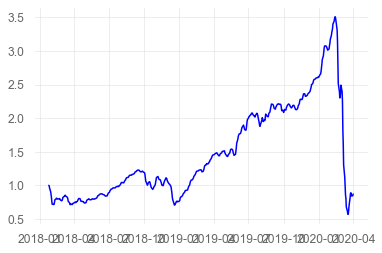

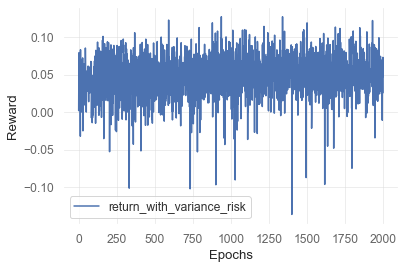

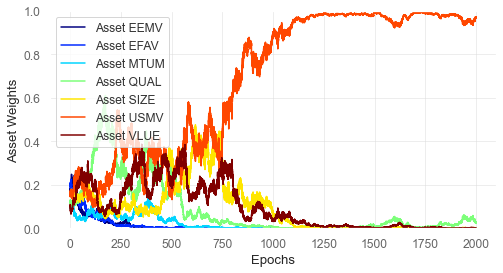

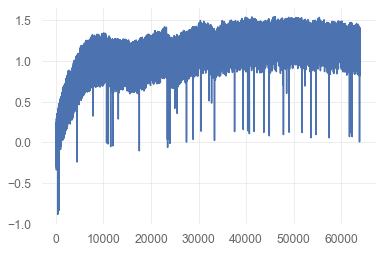



 50%|███████████████████████████████████████                                       | 2001/4000 [08:21<23:22,  1.43it/s]

 50%|███████████████████████████████████████                                       | 2002/4000 [08:21<17:58,  1.85it/s]

 50%|███████████████████████████████████████                                       | 2003/4000 [08:21<14:11,  2.35it/s]

 50%|███████████████████████████████████████                                       | 2004/4000 [08:22<13:17,  2.50it/s]

 50%|███████████████████████████████████████                                       | 2005/4000 [08:22<11:11,  2.97it/s]

 50%|███████████████████████████████████████                                       | 2006/4000 [08:22<09:27,  3.52it/s]

 50%|███████████████████████████████████████▏                                      | 2007/4000 [08:22<08:15,  4.02it/s]

 50%|███████████████████████████████████████▏                                      | 2008/4000 [08:22<07:31,  4.42it/s]

 50%|█████████████████████████

 52%|████████████████████████████████████████▎                                     | 2065/4000 [08:35<08:16,  3.90it/s]

 52%|████████████████████████████████████████▎                                     | 2066/4000 [08:35<08:12,  3.93it/s]

 52%|████████████████████████████████████████▎                                     | 2067/4000 [08:36<08:55,  3.61it/s]

 52%|████████████████████████████████████████▎                                     | 2068/4000 [08:36<09:53,  3.25it/s]

 52%|████████████████████████████████████████▎                                     | 2069/4000 [08:36<10:10,  3.17it/s]

 52%|████████████████████████████████████████▎                                     | 2070/4000 [08:37<10:28,  3.07it/s]

 52%|████████████████████████████████████████▍                                     | 2071/4000 [08:37<10:48,  2.97it/s]

 52%|████████████████████████████████████████▍                                     | 2072/4000 [08:37<10:50,  2.97it/s]

 52%|███████████████████████████

 53%|█████████████████████████████████████████▌                                    | 2129/4000 [08:49<08:18,  3.75it/s]

 53%|█████████████████████████████████████████▌                                    | 2130/4000 [08:49<08:23,  3.72it/s]

 53%|█████████████████████████████████████████▌                                    | 2131/4000 [08:49<07:42,  4.04it/s]

 53%|█████████████████████████████████████████▌                                    | 2132/4000 [08:50<07:31,  4.14it/s]

 53%|█████████████████████████████████████████▌                                    | 2133/4000 [08:50<07:29,  4.16it/s]

 53%|█████████████████████████████████████████▌                                    | 2134/4000 [08:50<07:42,  4.03it/s]

 53%|█████████████████████████████████████████▋                                    | 2135/4000 [08:50<08:05,  3.84it/s]

 53%|█████████████████████████████████████████▋                                    | 2136/4000 [08:51<07:43,  4.02it/s]

 53%|███████████████████████████

 55%|██████████████████████████████████████████▊                                   | 2193/4000 [09:03<06:52,  4.38it/s]

 55%|██████████████████████████████████████████▊                                   | 2194/4000 [09:03<07:03,  4.26it/s]

 55%|██████████████████████████████████████████▊                                   | 2195/4000 [09:04<07:57,  3.78it/s]

 55%|██████████████████████████████████████████▊                                   | 2196/4000 [09:04<08:15,  3.64it/s]

 55%|██████████████████████████████████████████▊                                   | 2197/4000 [09:04<08:14,  3.65it/s]

 55%|██████████████████████████████████████████▊                                   | 2198/4000 [09:04<07:33,  3.97it/s]

 55%|██████████████████████████████████████████▉                                   | 2199/4000 [09:04<07:03,  4.25it/s]

 55%|██████████████████████████████████████████▉                                   | 2200/4000 [09:05<06:49,  4.40it/s]

 55%|███████████████████████████

 56%|████████████████████████████████████████████                                  | 2257/4000 [09:17<06:11,  4.69it/s]

 56%|████████████████████████████████████████████                                  | 2258/4000 [09:17<05:53,  4.92it/s]

 56%|████████████████████████████████████████████                                  | 2259/4000 [09:17<05:30,  5.27it/s]

 56%|████████████████████████████████████████████                                  | 2260/4000 [09:17<05:34,  5.20it/s]

 57%|████████████████████████████████████████████                                  | 2261/4000 [09:17<05:28,  5.29it/s]

 57%|████████████████████████████████████████████                                  | 2262/4000 [09:18<05:30,  5.26it/s]

 57%|████████████████████████████████████████████▏                                 | 2263/4000 [09:18<05:34,  5.20it/s]

 57%|████████████████████████████████████████████▏                                 | 2264/4000 [09:18<05:19,  5.44it/s]

 57%|███████████████████████████

In [ ]:
# create environment and run Actor-Critic 

env_actor_critic_no_trace_train = DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_actor_critic_no_trace_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_actor_critic_no_trace = LinearAgent(environment=env_actor_critic_no_trace_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_actor_critic_no_trace.ACTOR_CRITIC_FIT(use_traces=False,max_iterations=max_iter, verbose=True)

In [ ]:
# perform backtest
backtest_actor_critic_no_trace = plot_backtest(linear_agent_actor_critic_no_trace, env_actor_critic_no_trace_test,  portfolio_df_test, model="Actor-Critic without Eligibility Traces")
backtest_actor_critic_no_trace.to_csv('temp_persisted_data/'+model_run+'backtest_actor_critic_no_trace.csv')

### Actor-Critic with Eligibility Traces

In [ ]:
# create environment and run Actor-Critic with Eligibility Traces 
env_actor_critic_trace_train = DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_actor_critic_trace_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_actor_critic_trace = LinearAgent(environment=env_actor_critic_trace_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_actor_critic_trace.ACTOR_CRITIC_FIT(use_traces=True,max_iterations=max_iter, verbose=True)

In [ ]:
# perform backtest 
backtest_actor_critic_trace = plot_backtest(linear_agent_actor_critic_trace, env_actor_critic_trace_test,  portfolio_df_test, model="Actor-Critic with Eligibility Traces")
backtest_actor_critic_trace.to_csv('temp_persisted_data/'+model_run+'backtest_actor_critic_trace.csv')